In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

## Базовые классы: дорожка, кубик, игрок

In [2]:
#Дорожка
class Path():
     def __init__(self,num,length):
            self.num=num
            self.length=length
            
#Кубик (особенно пригодится, если в игре потребуется 2 кубика)
class Dice:
    def __init__(self,n_sides=6):
        self.n=n_sides
        self.top=random.randint(1, n_sides)
        
    def roll(self):
        self.top=random.randint(1, self.n)
        return self.top
    
#Игрок
class Player:
    def __init__(self,p_name, p_path):
        self.name=p_name
        self.path=p_path
    current_cell = 0
    moves = 0
    last_move=0
    def dice_move(self, steps):
        self.moves=self.moves+1
        if self.current_cell+steps>self.path.length:
            self.current_cell = self.path.length
        else:
            self.current_cell = self.current_cell+steps
    def smn_move(self, steps):
        self.last_move=steps/self.path.length
        if self.current_cell+steps>self.path.length:
            self.current_cell = self.path.length
        else:
            self.current_cell = self.current_cell+steps
    def nullify(self):
        self.current_cell = 0
        self.moves = 0
            

## Классы различных игровых карт и колоды

In [3]:
#Добавляем класс базовой карточки, карточки с дуэлью и колоды
class Card():
    def __init__(self,c_name,c_class, c_descr, c_type):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        
class Card_compete_move():
    def __init__(self,c_name,c_class, c_descr, c_type, c_winner, c_loser):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        self.winner=c_winner
        self.loser=c_loser    
        
class Card_option():
    def __init__(self,c_name,c_class, c_descr, c_type, c_probs, c_A_who,c_A_action,c_B_who,c_B_action):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        self.probs=c_probs
        self.A_who=c_A_who
        self.A_action=c_A_action
        self.B_who=c_B_who
        self.B_action=c_B_action
        
class Card_event_move():
    def __init__(self,c_name,c_class, c_descr, c_type, c_who,c_what):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        self.who=c_who
        self.what=c_what
        
class Card_risk():
    def __init__(self,c_name,c_class, c_descr, c_type, c_probs_lv1,c_A_action, c_probs_lv2,c_B_action,c_C_action):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        self.probs_lv1=c_probs_lv1
        self.A_action=c_A_action
        self.probs_lv2=c_probs_lv2
        self.B_action=c_B_action
        self.C_action=c_C_action
        
class Card_disaster():
    def __init__(self,c_name,c_class, c_descr, c_type, c_player1, c_player2, c_player3, c_player4):
        self.card_name=c_name
        self.card_class=c_class
        self.descr=c_descr
        self.type=c_type
        self.player1=c_player1
        self.player2=c_player2
        self.player3=c_player3
        self.player4=c_player4
    def player_action(self,index):
        if index == 1:
            return self.player1
        elif index ==2:
            return self.player2
        elif index == 3:
            return self.player3
        else:
            return self.player4
        
class Deck():
    def __init__(self,the_cards):
        self.cards=the_cards.copy()
        self.all_cards=the_cards.copy()
        
    def shuffle(self):
        for i in range(len(self.cards)-1,0,-1):
            r=random.randint(0,i)
            self.cards[i],self.cards[r]=self.cards[r],self.cards[i]
            
    def get_card(self):
        return self.cards.pop()
    
    def renew_deck(self):
        self.cards=self.all_cards.copy()
        self.shuffle()


## Механики

In [4]:
#Добавляем необходимые вспомогательные функции: обмен игровыми позициями, выбор игрока, определение победителя/проигравшего
def change_paths(players_list):
    positions=[]
    lm_before=[]
    lm_after=[]
    move_list=[]
    for player in players_list:
        positions.append([player.path,player.current_cell])
        lm_before.append(player.current_cell/player.path.length)
    positions.append(positions.pop(0))
    for i in range(len(players_list)):
        players_list[i].path=positions[i][0]
        players_list[i].current_cell=positions[i][1]
        lm_after.append(players_list[i].current_cell/players_list[i].path.length)
        move_list.append([players_list[i].name,lm_after[i]-lm_before[i]])
    return move_list
        
def choose_player(current_player,players):
    players=players.copy()
    players.remove(current_player)
    r=random.randint(0,len(players)-1)
    return players[r]
        
def competition(players_list):
    players=players_list.copy()
    for i in range(len(players)-1,0,-1):
            r=random.randint(0,i)
            players[i],players[r]=players[r],players[i]
    return players

#проверка колоды и ее обновление 
def check_decks(decks):
    for deck in decks:
        if len(deck.cards)==0:
            deck.renew_deck()         

In [5]:
#вторая фаза хода (выполнение действия на карточке), в.т.ч. действие с картой опции
def card_action(player,players_list,current_dice_roll,missing_move,deck_trial, deck_event):
    if current_dice_roll<5:
        k=deck_trial.get_card()
        if k.type=='compete_move':
            comp_res=competition([player,choose_player(player,players_list)])
            move_list=[]
            for pl in players_list:
                if pl.name==comp_res[0].name:
                    pl.smn_move(k.winner)
                elif pl.name==comp_res[-1].name:
                    pl.smn_move(k.loser)
                else:
                    pl.smn_move(0)
                move_list.append([pl.name,pl.last_move])
                pl.smn_move(0)
            return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
            
        elif k.type=='risk':
            p=random.uniform(0, 1)
            move_list=[]
            if p<k.probs_lv1:
                missing_move.append(player)
                for pl in players_list:
                    move_list.append([pl.name,0])
                    pl.smn_move(0)
            else:
                p=random.uniform(0, 1)
                if p<k.probs_lv2:
                    player.smn_move(int(k.B_action))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                else:
                    player.smn_move(int(k.C_action))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
            return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
            
        elif k.type=='option':
            p=random.uniform(0, 1)
            move_list=[]
            if p<k.probs:
                if k.A_who=='player':
                    player.smn_move(int(k.A_action))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                else:
                    player.smn_move(int(k.A_action.split(",")[0]))
                    op=choose_player(player,players_list)
                    op.smn_move(int(k.A_action.split(",")[1]))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
            else:
                if k.B_who=='player':
                    if k.B_action =='miss_next_move':
                        missing_move.append(player)
                        for pl in players_list:
                            move_list.append([pl.name,0])
                            pl.smn_move(0)
                    elif k.B_action =='make_move':
                        for pl in players_list:
                            pl.smn_move(dice.roll())
                            move_list.append([pl.name,pl.last_move])
                            pl.smn_move(0)
                    else:
                        player.smn_move(int(k.B_action))
                        for pl in players_list:
                            move_list.append([pl.name,pl.last_move])
                            pl.smn_move(0)
                elif k.B_who=='any':
                    if k.B_action =='miss_next_move':
                        missing_move.append(player)
                        for pl in players_list:
                            move_list.append([pl.name,0])
                            pl.smn_move(0)
                else:
                    player.smn_move(int(k.B_action.split(",")[0]))
                    op=choose_player(player,players_list)
                    op.smn_move(int(k.B_action.split(",")[1]))
                    for pl in players_list:
                            move_list.append([pl.name,pl.last_move])
                            pl.smn_move(0)
                return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
                
        else:
            print(player.name,'took trial',player.current_cell)
                    
    else:
        k=deck_event.get_card()
        card_history.append([player.name,k.card_name,k.card_class]) 
        if k.type=='change_path':
            move_list=change_paths(players_list)
            return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
        elif k.type=='compete_move':
            move_list=[]
            s=players_list.copy()
            s.append(player)
            loser=choose_player(player,s)
            if k.who=='except_winner':
                s.remove(loser)
                loser.smn_move(0)
                for pl in s:
                    pl.smn_move(int(k.what))
                for pl in players_list:
                    move_list.append([pl.name,pl.last_move])
                    pl.smn_move(0)
            else:
                if k.what == 'make_move':
                    loser.smn_move(dice.roll())
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                else:
                    loser.smn_move(int(k.what))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
            return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]

        elif k.type=='disaster':
            move_list=[]
            for i in range(len(players_list)):
                if k.player_action(i) == 'miss_move_option':
                    p=random.uniform(0, 1)
                    if p<0.67: 
                        missing_move.append(players_list[i])
                        players_list[i].smn_move(0)
                else:
                    players_list[i].smn_move(int(k.player_action(i)))
                    move_list.append([players_list[i].name,players_list[i].last_move])
                    players_list[i].smn_move(0)
            return [players_list[i].name, players_list[i].moves,players_list[i].current_cell,k.card_name,k.card_class,move_list]
           
        elif k.type=='option':
            move_list=[]
            p=random.uniform(0, 1)
            if p<k.probs:
                if k.A_who=='last':
                    s=players_list.copy()
                    s.append(player)
                    loser=choose_player(player,s)
                    loser.smn_move(int(k.A_action))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                elif k.A_who=='all':
                    for pl in players_list:
                        move_list.append([pl.name,0])
                        pl.smn_move(0)
                    pass
                else:
                    player.smn_move(int(k.A_action.split(",")[0]))
                    op=choose_player(player,players_list)
                    op.smn_move(int(k.A_action.split(",")[1]))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
            else:
                if k.B_who=='all':
                    if k.B_action =='make_move':
                        for pl in players_list:
                            pl.smn_move(dice.roll())
                            move_list.append([pl.name,pl.last_move])
                            pl.smn_move(0)
                    else:
                        for pl in players_list:
                            pl.smn_move(int(k.B_action))
                            move_list.append([pl.name,pl.last_move])
                            pl.smn_move(0)
                else:
                    s=players_list.copy()
                    s.append(player)
                    op=choose_player(player,s)
                    op.smn_move(int(k.B_action))
                    for pl in players_list:
                        move_list.append([pl.name,pl.last_move])
                        pl.smn_move(0)
                return [player.name, player.moves,player.current_cell,k.card_name,k.card_class,move_list]
        else:
            print(player.name,'took event',k.type, k.card_name)
    


In [6]:
#Механика для вывода результатов
def gd_metric():
    metric = ''
    # спрашиваем ГД, какую метрику выдать: полезность или винрейты
    while metric !='card_usability' and metric != 'win_rate':
        metric = input('В качестве показателей доступны card_usability и win_rate: ')
    return(metric)

## Создаем все игровые элементы

In [7]:
#Cоздаем колоды карт событий и карт испытаний
#события меняющие местами
df=pd.read_csv("change_path.csv", sep=";")
event_cards = [(Card(row.card_name,row.card_class, row.description,row.type)) for index, row in df.iterrows()] 
#события с опциями
df=pd.read_csv("option.csv", sep=";")
event_cards.extend([(Card_option(row.card_name,row.card_class, row.description,row.type,row.probs,
                                  row.A_who,row.A_action,row.B_who,row.B_action))
               for index, row in df[df.card_class == 'event'].iterrows() ])

#события движение
df=pd.read_csv("event_move.csv", sep=";")
event_cards.extend([(Card_event_move(row.card_name,row.card_class, row.description,row.type,row.who, row.what))
               for index, row in df.iterrows() ])


#события риск
df=pd.read_csv("disaster.csv", sep=";")
event_cards.extend([(Card_disaster(row.card_name,row.card_class, row.description,row.type,
                                     row.player1,row.player2,row.player3,row.player4))
               for index, row in df.iterrows()])

#испытания опции
df=pd.read_csv("option.csv", sep=";")
trial_cards = [(Card_option(row.card_name,row.card_class, row.description,row.type,row.probs,
                                  row.A_who,row.A_action,row.B_who,row.B_action))
               for index, row in df[df.card_class == 'trial'].iterrows() ]

#испытания риск
df=pd.read_csv("risk.csv", sep=";")
trial_cards.extend([(Card_risk(row.card_name,row.card_class, row.description,row.type,
                                     row.probs_lv1,row.A_action, row.probs_lv2,row.B_action,row.C_action))
               for index, row in df.iterrows()])

#испытания, двигающие игроков
df=pd.read_csv("simple_move_compete.csv", sep=";")
trial_cards.extend([(Card_compete_move(row.card_name,row.card_class, row.description,row.type,row.winner,row.loser))
               for index, row in df.iterrows() ])

#Колоды
deck_trial=Deck(trial_cards)
deck_trial.shuffle()
k=deck_trial.get_card()
deck_trial.renew_deck()
print(vars(k))
print()

deck_event=Deck(event_cards)
deck_event.shuffle()
k=deck_event.get_card()
deck_event.renew_deck()
print(vars(k))

{'card_name': 'trap eye', 'card_class': 'trial', 'descr': 'Ловушка: объявите другим игрока, что вам выпала карта ловушки, но не показывайте ее содержание. Положите ее перед собой заданием вниз.\n«Глаз Алмаз»: незаметно подмигните другому игроку и передайте ему эту карту, чтобы он понял, что настал его черед отступать на 1 клетку назад, а вам ходить на 1 вперед. Но если вас заметили другие игроки, то на клетку назад идете вы.', 'type': 'option', 'probs': 0.6, 'A_who': 'player,any', 'A_action': '1,-1', 'B_who': 'player', 'B_action': '-1'}

{'card_name': 'tribute2', 'card_class': 'event', 'descr': 'Дань уважения 2: Бросайте кубик, чтобы определить, кому или чему отдается дань уважения. 1-2 – Растения, 3-4 – животные, 5-6 – реки. Все игроки по очереди, начиная с того, чей сейчас ход, должны называть представителя тех, кому отдается дань уважения. Тот, кто не может назвать представителя в течение трех секунд, отступает на клетку назад, и только один, тот, кто называл представителей без пром

In [8]:
#Инициализируем игру с 3 игроками
path_1 = Path(1,43)
path_2 = Path(2,30)
path_3 = Path(3,43)

player_A = Player('A', path_1)
player_B = Player('B', path_2)
player_C = Player('C', path_3)
players_list = [player_A,player_B,player_C]

dice = Dice()

## Тестировочная сессия

In [9]:
#Листы для "заметок"
card_history=[]
scores =[]

move_list=[]
for pl in players_list:
    move_list.append([pl.name,0])
    

In [10]:
#Цикл для 1000 партий
wins=pd.DataFrame(columns=['game_session', 'winner', 'cycles'])
history_df = pd.DataFrame(columns=['game_session', 'player', 'move','position','card_name','card_type','moves_done'])
game=1
G=1000
while game <G+1:
    for player in players_list:
        player.nullify()
    cycles=0
    winner = False
    missing_move=[]
    while winner==False:
        cycles=cycles+1
        for player in players_list:
            if player in missing_move:
                player.dice_move(0)
                h=[player.name, player.moves,player.current_cell,'missed_move','missed_move',move_list] #лист с нулями
                game_step = pd.Series([1]+h, index = history_df.columns)
                history_df = history_df.append(game_step, ignore_index=True)
                missing_move.remove(player)
                continue
            check_decks([deck_trial,deck_event])
            current_dice_roll=dice.roll()
            player.dice_move(current_dice_roll)
            if player.current_cell==player.path.length:
                wins=wins.append(pd.Series([game,player.name,cycles],index = wins.columns),ignore_index=True)
                for p in players_list:
                    scores.append(p.current_cell/p.path.length)
                #print("game session done")
                winner=True
                break
            else:
                h=card_action(player,players_list, current_dice_roll,missing_move,deck_trial, deck_event)
                game_step = pd.Series([game]+h, index = history_df.columns)
                history_df = history_df.append(game_step, ignore_index=True)
    game=game+1

### Сборка результатов

In [11]:
history_df = pd.merge(history_df,  
                     wins,  
                     on ='game_session',  
                     how ='left') 

In [12]:
all_cards=[]
for card in trial_cards:
    all_cards.append(card.card_name)
for card in event_cards:
    all_cards.append(card.card_name)
all_cards=list(set(all_cards))

total_sessions=[]
won_sessions=[]
card_type=[]
card_usability=[]
for card in all_cards:
    total_sessions.append(len(set(history_df[history_df.card_name==card].game_session)))
    won_sessions.append(len(set(history_df[(history_df.player==history_df.winner) & (history_df.card_name==card)].game_session)))
    card_type.append(set(history_df[history_df.card_name==card].card_type))

for card in all_cards:
    usability=0
    for index, row in history_df[(history_df.card_name==card)].iterrows():
        for pl in row['moves_done']:
            if pl[0]==row['player']:
                usability=usability+pl[1]
            else:
                usability=usability+pl[1]*-1
    card_usability.append(usability)

card_stats=pd.DataFrame(all_cards,columns=['card'])
card_stats['card_type']=card_type
card_stats['total_use']=total_sessions
card_stats['won']=won_sessions
card_stats['win_rate']=card_stats.won/card_stats.total_use
card_stats['card_usability']=card_usability

### Результаты

In [13]:
#Винрейты по игрокам
print("Game Stats:")
print("Number of players:", len(players_list))
print("Number of trial cards:", len(trial_cards))
print("Number of event cards:",len(event_cards))
print("Number of games:",len(wins))
print()

print("Average Score:",sum(scores)/len(scores))
print("Av. N. of cylces:",wins.cycles.mean())
print()

balance=True

for i in players_list:
    pl_win_rate=len(wins[(wins['winner']==i.name)])/G
    print(i.name,"win rate:",pl_win_rate, "while having path length:", i.path.length)
    if abs(pl_win_rate-1/len(players_list))>0.1:
        balance=False
    
if balance == True:
    print("Winrates among players seem balanced.")
else:
    print("Winrate balance is biased.")


Game Stats:
Number of players: 3
Number of trial cards: 32
Number of event cards: 18
Number of games: 1000

Average Score: 0.7621170542635703
Av. N. of cylces: 9.11

A win rate: 0.371 while having path length: 30
B win rate: 0.277 while having path length: 43
C win rate: 0.352 while having path length: 43
Winrates among players seem balanced.


В качестве показателей доступны card_usability и win_rate: win_rate


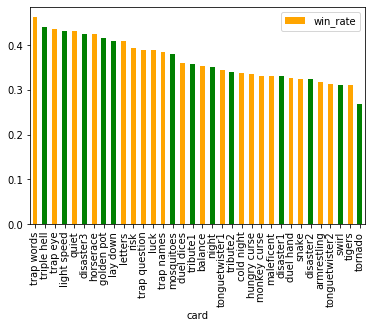

In [20]:
chosen_metric  = gd_metric()
card_stats=card_stats.sort_values(by=chosen_metric,ascending=False)    
colors=[]
for row in card_stats.card_type:
    if row=={'trial'}:
        colors.append('orange')
    else:
        colors.append('green')

card_stats.plot.bar(x='card', y=chosen_metric, rot=90,color=colors)

In [ ]:
#Винрейты по карточкам
card_stats=card_stats.sort_values(by='win_rate',ascending=False)    
colors=[]
for row in card_stats.card_type:
    if row=={'trial'}:
        colors.append('orange')
    else:
        colors.append('green')

card_stats.plot.bar(x='card', y='win_rate', rot=90,color=colors)


#usability по карточкам
card_stats=card_stats.sort_values(by='card_usability',ascending=False)    
colors=[]
for row in card_stats.card_type:
    if row=={'trial'}:
        colors.append('orange')
    else:
        colors.append('green')

card_stats.plot.bar(x='card', y='card_usability', rot=90,color=colors)

In [42]:
wins.sort_values(by='cycles',ascending=False)

,game_session,winner,cycles
854,855,A,15
458,459,B,15
527,528,A,15
170,171,A,14
810,811,A,14
...,...,...,...
76,77,A,5
574,575,B,5
780,781,C,5
728,729,C,4


In [43]:
history_df[(history_df['game_session']==143)]

,game_session,player,move,position,card_name,card_type,moves_done,winner,cycles
3696,143,A,1,2,cold night,trial,"[[A, 0.0], [B, 0.0], [C, 0.0]]",B,4
3697,143,B,1,8,luck,trial,"[[A, 0.11627906976744186], [B, 0.0930232558139...",B,4
3698,143,C,1,10,lay down,event,"[[A, 0], [B, 0], [C, 0]]",B,4
3699,143,A,2,12,tribute2,event,"[[A, -0.023255813953488372], [B, -0.0232558139...",B,4
3700,143,B,2,10,duel hand,trial,"[[A, 0.0], [B, 0.023255813953488372], [C, -0.0...",B,4
3701,143,C,2,12,swirl,event,"[[A, -0.046511627906976744], [B, 0.20077519379...",B,4
3702,143,A,3,14,trap names,trial,"[[A, 0.023255813953488372], [B, 0.0], [C, -0.0...",B,4
3703,143,C,2,10,disaster1,event,"[[A, 0.0], [B, 0.0], [C, -0.023255813953488372]]",B,4
3704,143,C,3,15,golden pot,event,"[[A, 0.0], [B, 0.16666666666666666], [C, 0.0]]",B,4
3705,143,A,4,17,luck,trial,"[[A, 0.046511627906976744], [B, 0.2], [C, 0.11...",B,4


In [47]:
history_df.head(11)

,game_session,player,move,position,card_name,card_type,moves_done,winner,cycles
0,1,A,1,0,trap eye,trial,"[[A, -0.023255813953488372], [B, 0], [C, 0]]",B,9
1,1,B,1,4,mosquitoes,event,"[[A, -0.023255813953488372], [B, -0.0333333333...",B,9
2,1,C,1,3,duel hand,trial,"[[A, 0.0], [B, -0.06666666666666667], [C, 0.02...",B,9
3,1,A,2,1,trap eye,trial,"[[A, -0.023255813953488372], [B, 0.0], [C, 0.0]]",B,9
4,1,C,1,2,disaster1,event,"[[A, 0.0], [B, 0.0], [C, -0.023255813953488372]]",B,9
5,1,C,2,7,disaster2,event,"[[A, 0.0], [B, -0.03333333333333333]]",B,9
6,1,A,3,8,luck,trial,"[[A, 0.09302325581395349], [B, 0.1333333333333...",B,9
7,1,B,3,9,risk,trial,"[[A, 0.0], [B, -0.1], [C, 0.0]]",B,9
8,1,C,3,15,hungry curse,trial,"[[A, 0], [B, 0], [C, 0]]",B,9
9,1,A,4,8,letters,trial,"[[A, -0.046511627906976744], [B, 0.0], [C, 0.0]]",B,9


## Подбор оптимальной колоды

### Функции создания элементов и прогона партий для оптимизации кода

In [14]:
#Функция формирования колод исходя из популяции

def make_decks(cards, equation_inputs, population):
    #Формируем колоду трайал исходя из хромосомы
    trial_cards=[]
    for index, row in cards[(cards.card_class=='trial')].iterrows():
        ind = equation_inputs.index(row['card_name'])
        n_repeats = population[ind]

        #Ищем и создаем карту
        if row['card_type']=='option':
            df=pd.read_csv("option.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            trial_card=Card_option(c.card_name,c.card_class, c.description,c.type,c.probs,
                                      c.A_who,c.A_action,c.B_who,c.B_action)
        elif row['card_type']=='risk':
            df=pd.read_csv("risk.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            trial_card=Card_risk(c.card_name,c.card_class, c.description,c.type,
                                         c.probs_lv1,c.A_action, c.probs_lv2,c.B_action,c.C_action)
        elif row['card_type']=='compete_move':
            df=pd.read_csv("simple_move_compete.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            trial_card=Card_compete_move(c.card_name,c.card_class, c.description,c.type,c.winner,c.loser)
        else:
            print("bad thing")

        for n in range(n_repeats):
            trial_cards.append(trial_card)

    #Формируем саму Колоду
    deck_trial=Deck(trial_cards)
    deck_trial.shuffle()

    #Формируем колоду событий исходя из хромосомы
    event_cards=[]
    for index, row in cards[(cards.card_class=='event')].iterrows():
        ind = equation_inputs.index(row['card_name'])
        n_repeats = population[ind]

        #Ищем и создаем карту
        if row['card_type']=='option':
            df=pd.read_csv("option.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            event_card = Card_option(c.card_name,c.card_class, c.description,c.type,c.probs,
                                      c.A_who,c.A_action,c.B_who,c.B_action)

        elif row['card_type']=='change_path':
            df=pd.read_csv("change_path.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            event_card =Card(c.card_name,c.card_class, c.description,c.type)

        elif row['card_type']=='compete_move':
            df=pd.read_csv("event_move.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            event_card =Card_event_move(c.card_name,c.card_class, c.description,c.type,c.who, c.what)

        elif row['card_type']=='disaster':
            df=pd.read_csv("disaster.csv", sep=";")
            c=df.loc[df['card_name'] == row['card_name']].iloc[0]
            event_card = Card_disaster(c.card_name,c.card_class, c.description,c.type,
                                         c.player1,c.player2,c.player3,c.player4)

        else:
            print("bad thing")

        for n in range(n_repeats):
            event_cards.append(event_card)

    #Формируем саму Колоду
    deck_event=Deck(event_cards)
    deck_event.shuffle()
    
    return deck_trial, deck_event

In [15]:
#Функция тестирования
def testing(num_of_sessions, players_list, card_history, deck_trial, deck_event):
    #Листы для "заметок"
    scores =[]

    move_list=[]
    for pl in players_list:
        move_list.append([pl.name,0])
    
    wins=pd.DataFrame(columns=['game_session', 'winner', 'cycles'])
    history_df = pd.DataFrame(columns=['game_session', 'player', 'move','position','card_name','card_type','moves_done'])
    game=1
    G=num_of_sessions
    while game <G+1:
        for player in players_list:
            player.nullify()
        cycles=0
        winner = False
        missing_move=[]
        while winner==False:
            cycles=cycles+1
            for player in players_list:
                if player in missing_move:
                    player.dice_move(0)
                    h=[player.name, player.moves,player.current_cell,'missed_move','missed_move',move_list] #лист с нулями
                    game_step = pd.Series([1]+h, index = history_df.columns)
                    history_df = history_df.append(game_step, ignore_index=True)
                    missing_move.remove(player)
                    continue
                check_decks([deck_trial,deck_event])
                current_dice_roll=dice.roll()
                player.dice_move(current_dice_roll)
                if player.current_cell==player.path.length:
                    wins=wins.append(pd.Series([game,player.name,cycles],index = wins.columns),ignore_index=True)
                    for p in players_list:
                        scores.append(p.current_cell/p.path.length)
                    #print("game session done")
                    winner=True
                    break
                else:
                    h=card_action(player,players_list, current_dice_roll,missing_move,deck_trial, deck_event)
                    game_step = pd.Series([game]+h, index = history_df.columns)
                    history_df = history_df.append(game_step, ignore_index=True)
        game=game+1
    return history_df, wins, scores


In [16]:
def calculate_winrates(players_list,wins,number_of_sessions):
    winrates=[]
    for player in players_list:
        winrates.append(len(wins[(wins['winner']==player.name)])/number_of_sessions)
    return winrates

### Функции необходимые для Генетического алгоритма

In [17]:
#Fitness function: Calculating the fitness value of each solution in the current population.
#As fitness value we would take average difference btw players winrates.
def cal_pop_fitness(cards, equation_inputs, new_population, players_list, num_of_sessions):
    fitness=[]
    for pop in new_population:
        deck_trial, deck_event = make_decks(cards, equation_inputs, pop)
        card_history=[]
        history_df, wins, scores = testing(num_of_sessions, players_list, card_history, deck_trial, deck_event)
        winrates = calculate_winrates(players_list,wins,num_of_sessions)
        #print(winrates)
        f=[]
        for i in range (len(winrates)):
            for j in range (i + 1, len(winrates)):
                f.append(abs(winrates[i] - winrates[j]))
        fitness.append(sum(f)/len(f))
    return fitness

# Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
#Best is the one with the lowest fitness function
def select_mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        fitness[min_fitness_idx] = 100000
    return parents

# Crossover to produce offsprings
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Mutation to change a random gene in each offspring randomly.
def mutation(offspring_crossover):

    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = np.random.randint(4)
        random_gene =np.random.randint(offspring_crossover.shape[1])
        offspring_crossover[idx, random_gene] = random_value
    return offspring_crossover

### Реализация ГА

In [20]:
#Necessary Parameters

cards=pd.read_csv("all_cards.csv")
# Inputs of cards
equation_inputs = cards.card_name.to_list()

#Number of parameters for optimization
num_cards=len(cards)

#N. of solutions per population
sol_per_pop = 10

# Defining the population size.
pop_size = (sol_per_pop,num_cards) #sol_per_pop chromosome where each chromosome has num_of_cards genes.

#Creating the initial population.
new_population = np.random.randint(4, size=pop_size)
new_population #12 примеров колод для 34 карт

#Setting number of generations
num_generations = 15

#Setting number of parents necessary
num_parents_mating = 3

In [21]:
#GA itself
for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measing the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(cards, equation_inputs, new_population, players_list, 100)
    print("Best Fitness of generation", generation, ": ", min(fitness))
    
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating)
    
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], num_cards))
    
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)
    
# Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

Generation :  0
Best Fitness of generation 0 :  0.013333333333333345
Generation :  1
Best Fitness of generation 1 :  0.01999999999999998
Generation :  2
Best Fitness of generation 2 :  0.013333333333333345
Generation :  3
Best Fitness of generation 3 :  0.01999999999999998
Generation :  4
Best Fitness of generation 4 :  0.04
Generation :  5
Best Fitness of generation 5 :  0.04666666666666667
Generation :  6
Best Fitness of generation 6 :  0.01999999999999998
Generation :  7
Best Fitness of generation 7 :  0.033333333333333326
Generation :  8
Best Fitness of generation 8 :  0.01999999999999998
Generation :  9
Best Fitness of generation 9 :  0.01999999999999998
Generation :  10
Best Fitness of generation 10 :  0.013333333333333345
Generation :  11
Best Fitness of generation 11 :  0.01999999999999998
Generation :  12
Best Fitness of generation 12 :  0.01999999999999998
Generation :  13
Best Fitness of generation 13 :  0.026666666666666655
Generation :  14
Best Fitness of generation 14 :  

### Результаты

In [23]:
# Getting the best solution after iterating finishing all generations.

#At first, the fitness is calculated for each solution in the final generation.
fitness = cal_pop_fitness(cards, equation_inputs, new_population, players_list, 100)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

print("Best solution fitness : ", fitness[best_match_idx[0][0]])
print("Best solution : ", new_population[best_match_idx[0][0], :])
solution=pd.DataFrame(cards.card_name.to_list(),columns=['card_name'])
solution['num_of_cards']=new_population[best_match_idx[0][0], :]
solution    


Best solution fitness :  0.006666666666666672
Best solution :  [3 0 3 2 1 3 0 2 1 2 1 1 1 1 3 0 0 1 1 3 1 3 3 1 2 2 1 0 2 0 2 0 3 1]


,card_name,num_of_cards
0,trap eye,3
1,snake,0
2,quiet,3
3,cold night,2
4,tigers,1
5,tonguetwister1,3
6,tonguetwister2,0
7,balance,2
8,letters,1
9,hungry curse,2
